IMPORTING ALL NECESSARY PACKAGES. MOST OF THEM ARE ALREADY IN THE ANACONDA DISTRIBUTION

In [ ]:
import asyncio
import nest_asyncio
import aiohttp
from understat import Understat
import codecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
#from halo import HaloNotebook as Halo
import subprocess
import os
from highlight_text import ax_text,fig_text
from mplsoccer import (VerticalPitch)
from PIL import Image, ImageFilter, ImageEnhance
from mplsoccer import add_image
from matplotlib.animation import FFMpegWriter

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143363f9d0, execution_count=481 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11429315810, raw_cell="import asyncio
import nest_asyncio
import aiohttp
.." transformed_cell="import asyncio
import nest_asyncio
import aiohttp
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [482]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382c290, execution_count=482 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417ce5c10, raw_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"" transformed_cell="os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W2sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [483]:
club="RasenBallsport Leipzig"  # CHANGE CLUB NAME HERE

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e16fd0, execution_count=483 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417e17ad0, raw_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." transformed_cell="club="RasenBallsport Leipzig"  # CHANGE CLUB NAME .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W3sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [484]:
with open('club_name.txt', 'w') as f:
    f.write(club)
    f.close

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141382d850, execution_count=484 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417cdcb50, raw_cell="with open('club_name.txt', 'w') as f:
    f.write(.." transformed_cell="with open('club_name.txt', 'w') as f:
    f.write(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [485]:
team_for_foto=""
if club == "RasenBallsport Leipzig":
    team_for_foto="RB Leipzig"
elif club == "FC Cologne":
    team_for_foto="FC Köln"
elif club== "Augsburg":
    team_for_foto="FC Augsburg"
elif club== "Borussia M.Gladbach":
    team_for_foto="Borussia Mönchengladbach"
else:
    team_for_foto=club
team_for_foto

'RB Leipzig'

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417e17510, execution_count=485 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416353bd0, raw_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." transformed_cell="team_for_foto=""
if club == "RasenBallsport Leipzi.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W5sZmlsZQ%3D%3D> result='RB Leipzig'>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [486]:
torneo="2025-2026"

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413eeced0, execution_count=486 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418aacb50, raw_cell="torneo="2025-2026"" transformed_cell="torneo="2025-2026"
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [487]:
foto_path=f'images/{team_for_foto}.png'

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417ab2f90, execution_count=487 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114194ce050, raw_cell="foto_path=f'images/{team_for_foto}.png'" transformed_cell="foto_path=f'images/{team_for_foto}.png'
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [488]:
%run -i undesstatteams.py

RasenBallsport Leipzig
[
    {
        "id": "30224",
        "isResult": true,
        "side": "a",
        "h": {
            "id": "117",
            "title": "Bayern Munich",
            "short_title": "BAY"
        },
        "a": {
            "id": "136",
            "title": "RasenBallsport Leipzig",
            "short_title": "RBL"
        },
        "goals": {
            "h": "6",
            "a": "0"
        },
        "xG": {
            "h": "3.29885",
            "a": "0.52226"
        },
        "datetime": "2025-08-22 18:30:00",
        "forecast": {
            "w": 0.8900577384272623,
            "d": 0.079364402800771,
            "l": 0.030575745650069434
        },
        "result": "l"
    },
    {
        "id": "30235",
        "isResult": true,
        "side": "h",
        "h": {
            "id": "136",
            "title": "RasenBallsport Leipzig",
            "short_title": "RBL"
        },
        "a": {
            "id": "280",
            "title": "FC Hei

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114134c8910, execution_count=488 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141636c290, raw_cell="%run -i undesstatteams.py" transformed_cell="get_ipython().run_line_magic('run', '-i undesstatt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114134c8910, execution_count=488 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141636c290, raw_cell="%run -i undesstatteams.py" transformed_cell="get_ipython().run_line_magic('run', '-i undesstatt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 114134c8910, execution_count=488 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141636c290, raw_cell="%run -i undesstatteams.py" transformed_cell="get_ipython().run_line_magic('run', '-i undesstatt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 114134c8910, execution_count=488 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141636c290, raw_cell="%run -i undesstatteams.py" transformed_cell="get_ipython().run_line_magic('run', '-i undesstatt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114134c8910, execution_count=488 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141636c290, raw_cell="%run -i undesstatteams.py" transformed_cell="get_ipython().run_line_magic('run', '-i undesstatt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [489]:
# Get csv from D://understatteams.py !!!!!
df_understat=pd.read_csv(f'{club}_seasons_shots.csv')

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114331764d0, execution_count=489 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433176390, raw_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." transformed_cell="# Get csv from D://understatteams.py !!!!!
df_unde.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [490]:
df_understat.head()

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,44,0.036,0.543,Julian Chabot,LeftFoot,OwnGoal,RasenBallsport Leipzig,VfB Stuttgart,NaN,0.000000
1,28,0.942,0.699,David Raum,LeftFoot,MissedShots,Bayern Munich,RasenBallsport Leipzig,Nicolas Seiwald,0.050276
2,28,0.926,0.319,Loïs Openda,RightFoot,BlockedShot,Bayern Munich,RasenBallsport Leipzig,NaN,0.046746
3,43,0.862,0.328,Xaver Schlager,RightFoot,BlockedShot,Bayern Munich,RasenBallsport Leipzig,Johan Bakayoko,0.054438
4,49,0.896,0.303,Johan Bakayoko,RightFoot,BlockedShot,Bayern Munich,RasenBallsport Leipzig,Loïs Openda,0.051910


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433175410, execution_count=490 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433175750, raw_cell="df_understat.head()" transformed_cell="df_understat.head()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X13sZmlsZQ%3D%3D> result=   minute      X      Y          player   shotType       result  \
0      44  0.036  0.543   Julian Chabot   LeftFoot      OwnGoal   
1      28  0.942  0.699      David Raum   LeftFoot  MissedShots   
2      28  0.926  0.319     Loïs Openda  RightFoot  BlockedShot   
3      43  0.862  0.328  Xaver Schlager  RightFoot  BlockedShot   
4      49  0.896  0.303  Johan Bakayoko  RightFoot  BlockedShot   

                   h_team                  a_team  player_assisted        xG  
0  RasenBallsp

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [491]:
own_goals_total=len(df_understat[df_understat['result']=='OwnGoal'])
own_goals_total

1

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143367f8d0, execution_count=491 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143367fb10, raw_cell="own_goals_total=len(df_understat[df_understat['res.." transformed_cell="own_goals_total=len(df_understat[df_understat['res.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X14sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [492]:
own_goals=df_understat[df_understat['result']=='OwnGoal']
own_goals['xG']=0.5
own_goals

C:\Users\enado\AppData\Local\Temp\ipykernel_9120\1559663483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  own_goals['xG']=0.5


,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,44,0.036,0.543,Julian Chabot,LeftFoot,OwnGoal,RasenBallsport Leipzig,VfB Stuttgart,NaN,0.5


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a2af910, execution_count=492 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a2ad350, raw_cell="own_goals=df_understat[df_understat['result']=='Ow.." transformed_cell="own_goals=df_understat[df_understat['result']=='Ow.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X15sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [493]:
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_league_players(
            "bundesliga",
            2025,
            team_title=club
        )
        squad=json.dumps(players, indent=4, ensure_ascii=False)
    with codecs.open(f'{club}_squad.json', "w", "utf-8") as jsonfile:
        jsonfile.write(squad)
        #json.dumps(jamal_json, indent=4)
        jsonfile.close() 

nest_asyncio.apply()
loop = asyncio.get_event_loop()
loop.run_until_complete(main())

squad_df=pd.read_json(f'{club}_squad.json')

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1cbd0, execution_count=493 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417b1c750, raw_cell="async def main():
    async with aiohttp.ClientSes.." transformed_cell="async def main():
    async with aiohttp.ClientSes.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [494]:
squad=squad_df['player_name'].unique()
squad

array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 'Kosta Nedeljkovic',
       'Ezechiel Banzuzi', 'Andrija Maksimovic', 'Samba Konate'],
      dtype=object)

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418e67d50, execution_count=494 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e67c50, raw_cell="squad=squad_df['player_name'].unique()
squad" transformed_cell="squad=squad_df['player_name'].unique()
squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X20sZmlsZQ%3D%3D> result=array(['Christoph Baumgartner', 'Yan Diomande', 'Rômulo', 'David Raum',
       'Assan Ouédraogo', 'Xaver Schlager', 'Antonio Nusa',
       'Johan Bakayoko', 'Willi Orban', 'Bote Baku', 'Castello Lukeba',
       'Tidiam Gomis', 'Conrad Harder', 'Timo Werner', 'Kevin Kampl',
       'Benjamin Henrichs', 'Péter Gulácsi', 'Lukas Klostermann',
       'Xavi Simons', 'El Chadaille Bitshiabu', 'Loïs Openda',
       'Nicolas Seiwald', 'Max Finkgrafe', 

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [495]:
"Paul Nebel" in squad

False

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dc90, execution_count=495 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11413ca7350, raw_cell=""Paul Nebel" in squad" transformed_cell=""Paul Nebel" in squad
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X21sZmlsZQ%3D%3D> result=False>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [496]:
own_goals_len=len(own_goals[~own_goals['player'].isin(squad)])
own_goals_len

1

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1142f4d0c50, execution_count=496 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418e52bd0, raw_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." transformed_cell="own_goals_len=len(own_goals[~own_goals['player'].i.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X22sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [497]:
ogf=own_goals[~own_goals['player'].isin(squad)]
ogf

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,44,0.036,0.543,Julian Chabot,LeftFoot,OwnGoal,RasenBallsport Leipzig,VfB Stuttgart,NaN,0.5


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418a8dd50, execution_count=497 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418a8f0d0, raw_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." transformed_cell="ogf=own_goals[~own_goals['player'].isin(squad)]
og.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X23sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [498]:
own_goals_for=0
for player in own_goals['player']:
    if player not in squad:
        own_goals_for+=1
own_goals_for

1

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418abda50, execution_count=498 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11418abfe50, raw_cell="own_goals_for=0
for player in own_goals['player']:.." transformed_cell="own_goals_for=0
for player in own_goals['player']:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X24sZmlsZQ%3D%3D> result=1>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [499]:
# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. SINCE WE WILL BE USING OPTA AXES WHICH GO FROM 100 to 100, WE NEED TO
# SCALE BOTH THESE UPTO 100

df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

#df_understat['result'].unique()

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114290aa6d0, execution_count=499 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114160d7490, raw_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." transformed_cell="# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. S.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X25sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [500]:
df_understat[df_understat['result']=='OwnGoal']

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,44,3.6,54.299999,Julian Chabot,LeftFoot,OwnGoal,RasenBallsport Leipzig,VfB Stuttgart,NaN,0.0


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417d45c50, execution_count=500 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1142f44c790, raw_cell="df_understat[df_understat['result']=='OwnGoal']" transformed_cell="df_understat[df_understat['result']=='OwnGoal']
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X26sZmlsZQ%3D%3D> result=   minute    X          Y         player  shotType   result  \
0      44  3.6  54.299999  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.0  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [501]:
#pip install mplsoccer
#pip install highlight-text

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417bec2d0, execution_count=501 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11419a91510, raw_cell="#pip install mplsoccer
#pip install highlight-text" transformed_cell="#pip install mplsoccer
#pip install highlight-text.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

WE WILL CHANGE SOME OF THE BASIC PARAMETERS USING THE rcParams method OF MPL

In [502]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Franklin Gothic Medium Cond'
mpl.rcParams['legend.fontsize'] = 12


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 114291b3310, execution_count=502 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11415d8f850, raw_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." transformed_cell="background = '#D6DBD9'
text_color = 'black'
mpl.rc.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X32sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [503]:
#mpl.font_manager.FontManager.get_font_names(mpl)
ogf

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,44,0.036,0.543,Julian Chabot,LeftFoot,OwnGoal,RasenBallsport Leipzig,VfB Stuttgart,NaN,0.5


Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428cd1f50, execution_count=503 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11414877c90, raw_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." transformed_cell="#mpl.font_manager.FontManager.get_font_names(mpl)
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X33sZmlsZQ%3D%3D> result=   minute      X      Y         player  shotType   result  \
0      44  0.036  0.543  Julian Chabot  LeftFoot  OwnGoal   

                   h_team         a_team player_assisted   xG  
0  RasenBallsport Leipzig  VfB Stuttgart             NaN  0.5  >,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [504]:
#if torch.cuda.is_available():
 #   device = torch.device("cuda")
#else:
 #   device = torch.device("cpu")
    
#print("using", device, "device")

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11428ca3810, execution_count=504 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11428ca3110, raw_cell="#if torch.cuda.is_available():
 #   device = torch.." transformed_cell="#if torch.cuda.is_available():
 #   device = torch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

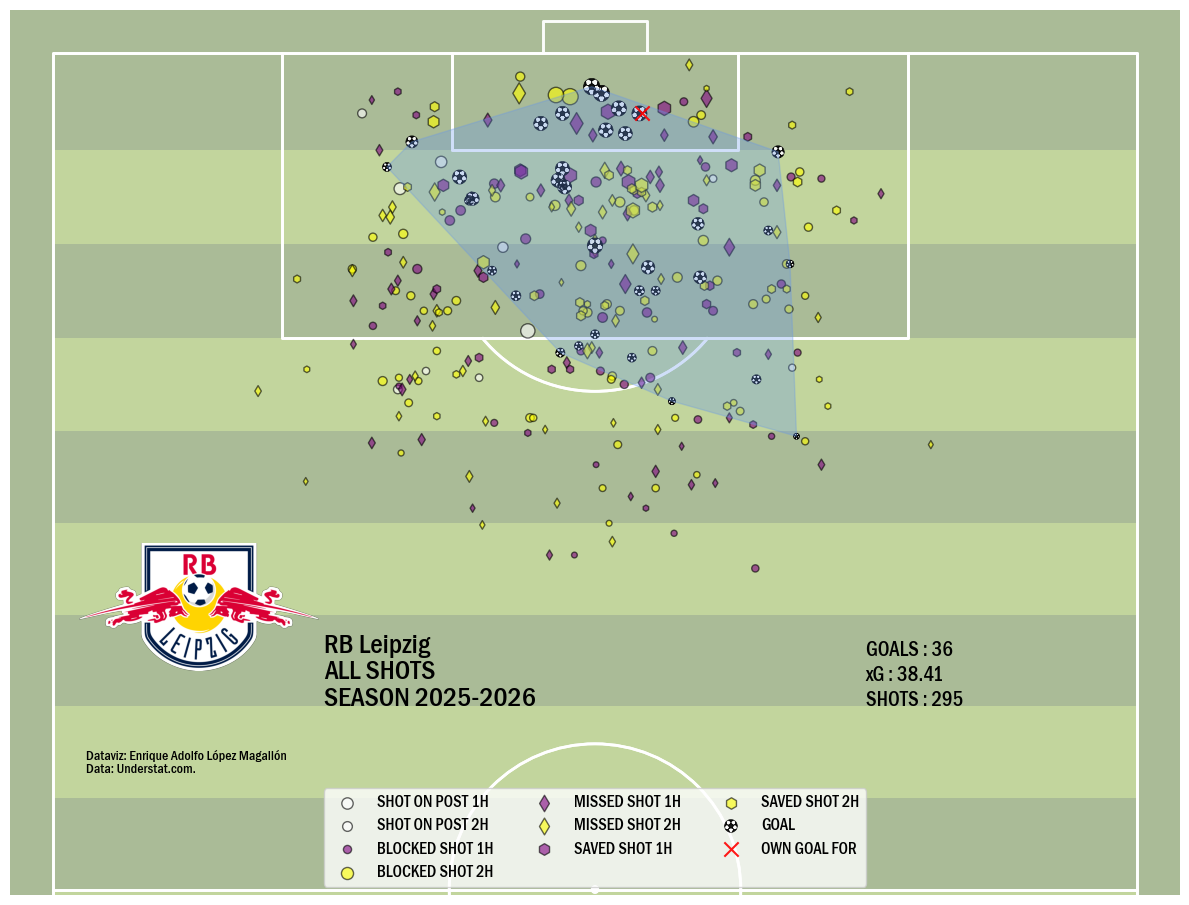

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11413e82850, execution_count=505 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11416041d50, raw_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." transformed_cell="# SETTING UP THE AXES
#fig, ax = plt.subplots(figs.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [505]:
# SETTING UP THE AXES
#fig, ax = plt.subplots(figsize=(10,12))
#ax.axis('off')
#fig.set_facecolor(background)

#SETTING UP THE MPL AXIS FOR THE FIRST TEAM
pitch = pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line 
    half=True,  # half of a pitch
    goal_type='box',
    goal_alpha=0.8, 
    pitch_type='opta',
    pitch_color='#aabb97',
    stripe=True,
    stripe_color='#c2d59d',
    line_color='white')  

fig, ax = pitch.draw(figsize=(12, 10))

#PLOTTING HTEAM
#df_fil = df_understat.loc[df_understat['HomeAway']=='h']
df_fil = df_understat
#df_hOG = df_fil[df_fil['HomeAway']=='a']
#df_fil = df_a
#df_hOG = df_fil[df_fil['HomeAway']=='h']
df_h1H = df_fil[df_fil['minute']<=45]
df_h2H = df_fil[df_fil['minute']>45]

#PLOTTING SHOTS TEAM 1 PER TYPE AND HALF.LABELS APPEAR ONLY IF VARIABLE IS FILLED


if "ShotOnPost" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='ShotOnPost']['X'],df_h1H[df_h1H['result']=='ShotOnPost']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='ShotOnPost']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='white', ax=ax, label="SHOT ON POST 1H")

if "ShotOnPost" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='ShotOnPost']['X'],df_h2H[df_h2H['result']=='ShotOnPost']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='ShotOnPost']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='white', ax=ax, label="SHOT ON POST 2H")
    
if "BlockedShot" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='BlockedShot']['X'],df_h1H[df_h1H['result']=='BlockedShot']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='BlockedShot']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="BLOCKED SHOT 1H")

if "BlockedShot" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='BlockedShot']['X'],df_h2H[df_h2H['result']=='BlockedShot']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='BlockedShot']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="BLOCKED SHOT 2H")

if "MissedShots" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='MissedShots']['X'],df_h1H[df_h1H['result']=='MissedShots']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='MissedShots']['xG'])*150, marker='d', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="MISSED SHOT 1H")

if "MissedShots" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='MissedShots']['X'],df_h2H[df_h2H['result']=='MissedShots']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='MissedShots']['xG'])*150, marker='d', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="MISSED SHOT 2H")
    
if "SavedShot" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='SavedShot']['X'],df_h1H[df_h1H['result']=='SavedShot']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='SavedShot']['xG'])*150, marker='h', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="SAVED SHOT 1H")

if "SavedShot" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='SavedShot']['X'],df_h2H[df_h2H['result']=='SavedShot']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='SavedShot']['xG'])*150, marker='h', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="SAVED SHOT 2H")
    


#NOW PLOTTING THE GOALS
if "Goal" in iter(df_fil['result']):
    pitch.scatter(df_fil[df_fil['result']=='Goal']['X'],df_fil[df_fil['result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['result']=='Goal']['xG'])*150, marker='football', alpha=0.9,
              edgecolors='black', facecolor='red', ax=ax, label="GOAL")
    hull=pitch.convexhull(df_fil[df_fil['result']=='Goal']['X'], df_fil[df_fil['result']=='Goal']['Y'])
    pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)

if "OwnGoal" in iter(ogf['result']):
    pitch.scatter(100-ogf[ogf['result']=='OwnGoal']['X']*100,100-ogf[df_fil['result']=='OwnGoal']['Y']*100, 
              s=np.sqrt(ogf[ogf['result']=='OwnGoal']['xG'])*150, marker='x', alpha=0.9,
              edgecolors='red', facecolor='red', ax=ax, label="OWN GOAL FOR")
    #hull=pitch.convexhull(df_fil[df_fil['result']=='OwnGoal']['X'], df_fil[df_fil['result']=='OwnGoal']['Y'])
    #pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
#OWNGOALS
#if len(df_hOG) >0:
 #   pitch.scatter(df_hOG[df_hOG['result']=='Goal']['X'],df_hOG[df_hOG['result']=='Goal']['Y'], 
  #            s=np.sqrt(df_hOG[df_hOG['result']=='Goal']['xG'])*150, marker='x', alpha=0.9,
   #           edgecolors='black', facecolor='orange', ax=ax_opta1, label='AUTOGOL DEL RIVAL')


# ADDING THE LEGEND
ax.legend(loc='lower center', ncol=3)#.get_texts()[0].set_color("black")

ax.text(25,64,'GOALS : '+str(len(df_fil[df_fil['result']=='Goal'])+ int(own_goals_for)), weight='bold', size=15)
ax.text(25,62.5,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax.text(25,61,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax.text(75, 61, f'{team_for_foto}\nALL SHOTS\nSEASON {torneo}', weight='bold', size=20)

# Use a direct file path instead of urlopen for local files
image_path = foto_path

# Check if the file exists before trying to open it
if os.path.exists(image_path):
    image = Image.open(image_path)
    ax_image = add_image(image, fig, left=0.07, bottom=0.245, width=0.2, height=0.2)
else:
    print(f"Warning: Image file not found at {image_path}")
    # Optionally continue without the image


pitch.draw(ax=ax)

# ADDING A FOOTER
ax.text(97,57,'Dataviz: Enrique Adolfo López Magallón\nData: Understat.com.')# Comparison with <forwards>'+
 #       ' with more than '+str(no_90s)+' 90s('+str(no_90s*90)+' minutes).',
  #      size=12, highlight_textprops=[{'color':'#EF8804'}], weight = 'bold')


#EXPORT TO IMG

plt.savefig(f'{club}_shots.png',dpi=300,facecolor=background)

In [506]:
shots_grouped=df_fil.groupby('minute').size()

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11417b1ae90, execution_count=506 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11417a7b850, raw_cell="shots_grouped=df_fil.groupby('minute').size()" transformed_cell="shots_grouped=df_fil.groupby('minute').size()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X36sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [507]:
shots_grouped


minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11418ad4090, execution_count=507 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 114329ed290, raw_cell="shots_grouped
" transformed_cell="shots_grouped
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X40sZmlsZQ%3D%3D> result=minute
1     3
2     2
3     4
4     3
5     3
     ..
92    6
93    6
94    4
95    1
96    1
Length: 94, dtype: int64>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [508]:
shots_grouped.sum()

np.int64(295)

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433199a50, execution_count=508 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143319a710, raw_cell="shots_grouped.sum()" transformed_cell="shots_grouped.sum()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X41sZmlsZQ%3D%3D> result=np.int64(295)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [509]:
len(df_fil)

295

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1143365e8d0, execution_count=509 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143365f6d0, raw_cell="len(df_fil)" transformed_cell="len(df_fil)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X42sZmlsZQ%3D%3D> result=295>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [510]:
def is_cuda_available_for_ffmpeg():
    try:
        # Check if FFmpeg is installed with CUDA support
        result = subprocess.run(
            ['ffmpeg', '-hide_banner', '-encoders'],
            capture_output=True, text=True, check=True
           )
        return 'h264_qsv' in result.stdout
    except Exception:
        return False
   
   # Use CUDA acceleration if available, otherwise fall back to CPU
if is_cuda_available_for_ffmpeg():
    codec = 'h264_qsv'
    extra_args = ['-hwaccel', 'cuda', '-hwaccel_output_format', 'cuda', '-preset', 'fast']
    print("Using CUDA acceleration for rendering")
else:
    codec = 'h264'
    extra_args = ['-preset', 'medium']
    print("CUDA acceleration not available, using CPU rendering")
   

Using CUDA acceleration for rendering
Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433685410, execution_count=510 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 11433684910, raw_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." transformed_cell="def is_cuda_available_for_ffmpeg():
    try:
     .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X43sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [511]:
df_fil['minute'].max()

np.int64(96)

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 11433698790, execution_count=511 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1143369a210, raw_cell="df_fil['minute'].max()" transformed_cell="df_fil['minute'].max()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X44sZmlsZQ%3D%3D> result=np.int64(96)>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Creating animation with 2060 frames


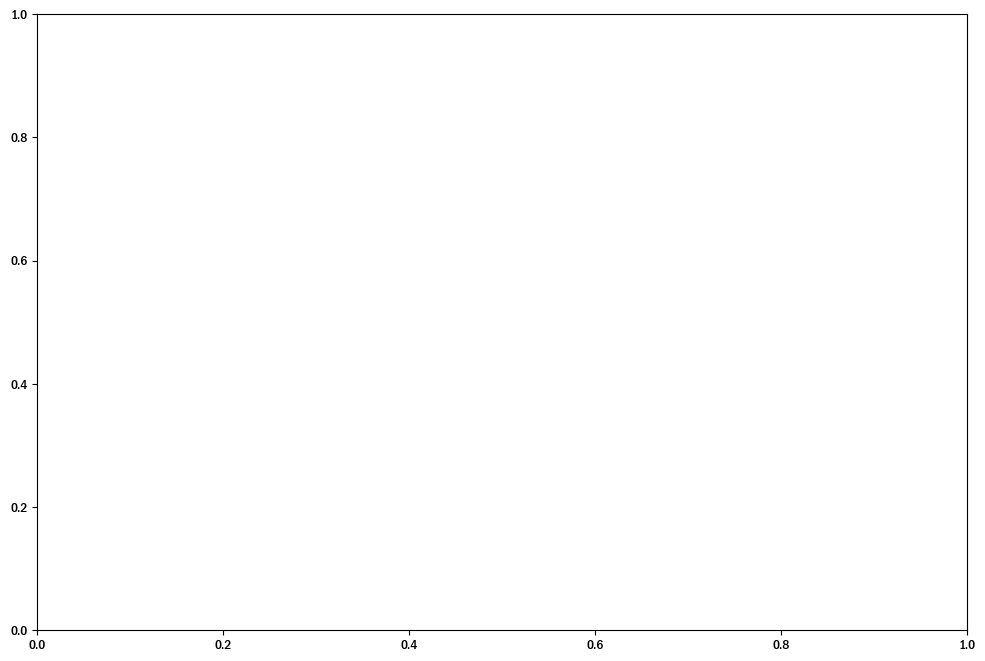

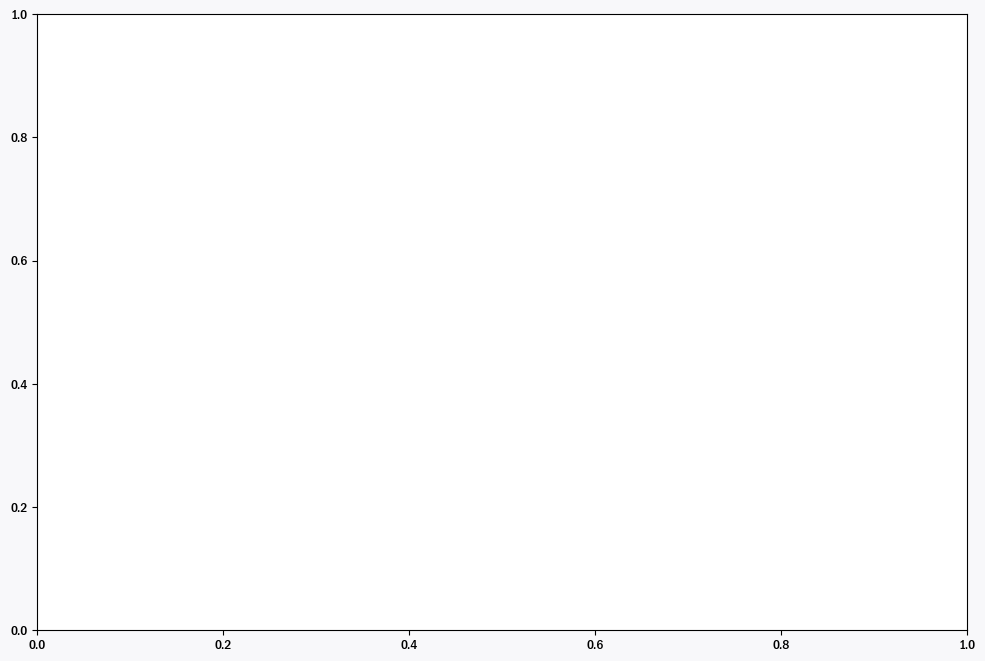

Available animation writers: ['pillow', 'ffmpeg', 'ffmpeg_file', 'html']
Using NVIDIA NVENC hardware encoding
Saving animation...
Animation saved successfully!
Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011413C823E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114149F72E0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AAC4A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011418D41C60> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x0000011417AD4360> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x00000114194EF6A0> (for post_run_cell), with arguments args (<ExecutionResult object at 1141a862dd0, execution_count=512 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1141a861310, raw_cell="# Function to prepare a background image that won'.." transformed_cell="# Function to prepare a background image that won'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/f%3A/Futbol/Fut_animation/teams_shotsVideoCUDA2026.ipynb#X45sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

In [512]:
# Function to prepare a background image that won't interfere with visualization
def prepare_background_image(image_path, target_width, target_height, blur_amount=3, brightness=1.3, saturation=0.7):
    """
    Prepare a background image by:
    1. Resizing to match the target dimensions
    2. Applying blur for subtlety
    3. Adjusting brightness and saturation
    
    Parameters:
    - image_path: Path to the background image
    - target_width, target_height: Desired dimensions
    - blur_amount: How much to blur (higher = more blur)
    - brightness: Brightness factor (>1 = brighter, <1 = darker)
    - saturation: Saturation factor (>1 = more saturated, <1 = less saturated)
    
    Returns:
    - Processed image as numpy array
    """
    try:
        # Open the image
        img = Image.open(image_path)
        
        # Convert to RGB mode if it's not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to match target dimensions
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        # Apply blur for subtlety
        img = img.filter(ImageFilter.GaussianBlur(blur_amount))
        
        # Adjust brightness
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(brightness)
        
        # Adjust saturation
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(saturation)
        
        # Convert to numpy array for matplotlib
        return np.array(img)
    
    except Exception as e:
        print(f"Error processing background image: {e}")
        # Return a default subtle gradient background
        return create_gradient_background(target_width, target_height)

# Create a gradient background as fallback
def create_gradient_background(width, height, color1=(245, 245, 250), color2=(225, 225, 240)):
    """Create a subtle gradient background"""
    background = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        for c in range(3):
            background[y, :, c] = color1[c] * (1 - ratio) + color2[c] * ratio
    return background

# Set up figure dimensions in inches and DPI for high resolution
fig_width, fig_height = 12, 8
dpi = 100

# Calculate pixel dimensions
pixel_width, pixel_height = int(fig_width * dpi), int(fig_height * dpi)

# Try to load the background image, fall back to gradient if there's an issue
try:
    background_img = prepare_background_image(
        foto_path,
        pixel_width, 
        pixel_height,
        blur_amount=5,
        brightness=1.2,
        saturation=0.6
    )
except Exception as e:
    print(f"Falling back to gradient background: {e}")
    background_img = create_gradient_background(pixel_width, pixel_height)

# Precompute data for efficiency
df_fil = df_understat
max_minute = df_fil['minute'].max()
shot_counts = df_fil.groupby('minute').size()
minutes = list(range(0, int(max_minute) + 1))
max_count = shot_counts.max()

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

def update(frame):
    ax.clear()
    # Calculate which minute we're showing and how far along the growth we are
    current_minute = int(frame) + 1
    growth_fraction = frame - int(frame)  # Decimal part represents growth progress
    
    # Create arrays for the current state of the animation
    current_counts = np.zeros(len(minutes))
    for i, minute in enumerate(minutes):
        if minute < current_minute:
            # Previous minutes are fully grown
            current_counts[i] = shot_counts.get(minute, 0)
        elif minute == current_minute:
            # Current minute is growing
            current_counts[i] = shot_counts.get(minute, 0) * growth_fraction
        # else 0
    
    # Calculate total shots efficiently
    total_shots = current_counts.sum()
    
    # Add background image with careful alpha tuning
    ax.imshow(background_img, aspect='auto', 
              extent=[0, max_minute + 1, 0, max_count + 1], 
              alpha=0.15,  # Very subtle background
              zorder=0)    # Ensure it's behind all other elements
    
    # Add a semi-transparent overlay to improve readability
    ax.add_patch(plt.Rectangle((0, 0), max_minute + 1, max_count + 1, 
                              color='white', alpha=0.3, zorder=1))
    
    # Create stem plot with magenta lines and orange dots (higher zorder to be on top)
    markerline, stemlines, baseline = ax.stem(minutes, current_counts, 
                                             linefmt='m-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, markersize=8, color='orange', zorder=3)  # Orange dots
    plt.setp(stemlines, linewidth=2, color='magenta', zorder=2)   # Magenta lines
    plt.setp(baseline, visible=False)  # Hide baseline for cleaner look
    
    # Set axis limits and labels
    ax.set_xlim(0, max_minute + 1)
    ax.set_ylim(0, max_count + 1)
    ax.set_xlabel('Minutes - all matches', weight='bold', size=12)
    ax.set_ylabel('Number of Shots', weight='bold', size=12)
    
    # Style the grid for better visibility over background
    ax.grid(True, linestyle='--', alpha=0.6, color='gray', zorder=1)

    # Add title and information with enhanced visibility
    current_display_minute = current_minute if growth_fraction == 0 else f"{current_minute-1}→{current_minute}"
    ax.set_title(f'{team_for_foto} Shot Count per Minute (Minute: {current_display_minute})', 
                weight='bold', size=15)
    
    # Add text with semi-transparent background for better readability
    text_box_props = dict(
        boxstyle='round,pad=0.5',
        facecolor='white',
        alpha=0.7,
        edgecolor='gray'
    )
    
    ax.text(max_minute * 0.7, ax.get_ylim()[1] * 0.9, 
            f'Total Shots: {int(total_shots)}', 
            weight='bold', size=15, 
            bbox=text_box_props,
            zorder=4)
    
    ax.text(max_minute * 0.7, ax.get_ylim()[1] * 0.1, 
            'Copyright: Enrique Adolfo López Magallón\nData: Understat.com.',
            bbox=text_box_props,
            zorder=4)
    
    # Ensure proper layout
    fig.tight_layout()
    
    return fig, ax

# Create figure and axis with a complementary background color
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi, 
                      facecolor='#f8f8fa')  # Very light blue-gray background

# Create animation with frames for growing each minute
frames_per_minute = 20  # Set this to your desired value (typically same as fps)
all_frames = np.linspace(0, max_minute, int(max_minute) * frames_per_minute)

fps = 20  # Based on your writer fps setting
freeze_frames = int(7 * fps)  # 7 seconds worth of frames
last_frame = int(max_minute)  # The last frame value
freeze_extension = [last_frame] * freeze_frames
all_frames = np.append(all_frames, freeze_extension)
            
print(f"Creating animation with {len(all_frames)} frames")

# Create animation
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=all_frames,
    interval=50,  # Faster animation (50ms per frame)
    blit=False,
    repeat=False
)

# Show the animation
plt.show()

# Function to detect available hardware encoder
def get_hardware_encoder():
    try:
        result = subprocess.run(['ffmpeg', '-hide_banner', '-encoders'], capture_output=True, text=True, check=True)
        encoders = result.stdout
        if 'h264_nvenc' in encoders:
            print("Using NVIDIA NVENC hardware encoding")
            return 'h264_nvenc', ['-preset', 'fast']
        elif 'h264_qsv' in encoders:
            print("Using Intel Quick Sync Video hardware encoding")
            return 'h264_qsv', ['-preset', 'fast']
        elif 'h264_amf' in encoders:
            print("Using AMD AMF hardware encoding")
            return 'h264_amf', ['-usage', 'transcoding', '-quality', 'speed']
        else:
            print("No hardware encoder found, using CPU encoding")
            return 'libx264', ['-preset', 'fast']
    except Exception as e:
        print(f"Error detecting hardware encoder: {e}, using CPU encoding")
        return 'libx264', ['-preset', 'fast']

# Save the animation
available_writers = animation.writers.list()
print(f"Available animation writers: {available_writers}")

if 'ffmpeg' in available_writers:
    # Detect hardware encoder
    codec, hw_extra_args = get_hardware_encoder()
    
    # Configure FFmpeg with hardware acceleration if available
    ffmpeg_writer = animation.FFMpegWriter(
        fps=fps,
        metadata=dict(artist='Enrique Adolfo Lopez Magallon'),
        bitrate=5000,  # Higher bitrate for better quality
        codec=codec,
        extra_args=hw_extra_args + [
            '-crf', '23',  # Reasonable quality (lower = better quality)
            '-pix_fmt', 'yuv420p',  # Pixel format for better compatibility
            '-threads', '0'  # Use all available CPU threads (for CPU fallback)
        ]
    )

    # Save the animation
    print("Saving animation...")
    ani.save(f'{club}_shots_animation_hw.mp4', writer=ffmpeg_writer, dpi=300)
    print("Animation saved successfully!")
elif 'pillow' in available_writers:
    writer = animation.PillowWriter(fps=fps)
    ani.save(f'{club}_shot_counts_stem_animation.gif', writer=writer, dpi=150)
else:
    print("No suitable writer found.")